In [3]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils

In [4]:
main_path = '/home/rfradkin/xom/'
raw_tess_path = '/scratch/data/tess/lcur/spoc/raws/'
tess_metad_path = '/data/scratch/data/tess/meta/'
xom_data_path = '/data/scratch/data/moon/'

### GPU Setup

In [5]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  9% |
|  2 |  0% |  9% |
|  3 |  0% |  9% |


In [6]:
# All GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
mirror_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


### Data Preprocessing

In [7]:
datas = 'padde_cuts-1_1-parti-1636835330.0437317.pkl'

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

In [8]:
numbe_sampl = -1

# Create a shuffled sample of the data
rando_shuff_x_data = raw_x_data[utils.retur_rando_sampl(
    numbe_sampl, len(raw_x_data))]
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1]['plane_moon_cut_injec'] or norma_full_x_data[i, -1, 1]['plane_cut_injec']

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

32.94% of the dataset contains a full injection


In [9]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train_np = np.array(x_data[:split])
full_x_train = norma_full_x_data[:split]
x_test_np = np.array(x_data[split:stop])
full_x_test = norma_full_x_data[split:stop]
y_train_np = y_data[:split]
y_test_np = y_data[split:stop]

In [10]:
# Mask the data
masking = layers.Masking(mask_value=0., input_shape = (1900, 1))

x_train_unmas = tf.convert_to_tensor(x_train_np)
x_test_unmas = tf.convert_to_tensor(x_test_np)
y_train = tf.convert_to_tensor(y_train_np)
y_test = tf.convert_to_tensor(y_test_np)
x_train = masking(x_train_unmas)
x_test = masking(x_test_unmas)

### Training

In [9]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{dataset}_{int(time.time())}')
early_stopp = EarlyStopping(monitor='val_accuracy', patience = 5)
resto_valid_accur = utils.resto_best_valid_accur()

callb = [resto_valid_accur, early_stopp]#, tensorboard]

In [10]:
# Model

l2_norma_gradi = 0.25
with mirror_strat.scope():
    model = keras.Sequential()

    model.add(
        layers.GRU(68,
                   activation='tanh',
                   input_shape=(1900, 1),
                   return_sequences=True))
    model.add(layers.GRU(48, activation='tanh'))

    model.add(layers.Dense(40, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Nadam(learning_rate=3e-4,
                                    clipnorm=l2_norma_gradi)
    model.compile(loss='BinaryCrossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1900, 68)          14484     
_________________________________________________________________
gru_1 (GRU)                  (None, 48)                16992     
_________________________________________________________________
dense (Dense)                (None, 40)                1960      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                656       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [12]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=20,
                    callbacks=callb,
                    validation_data=(x_test, y_test))

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 12 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/t

### Testing

In [11]:
start = 0
stop = None

x_full_predi_data = full_x_test[start:stop]
x_predi_data = x_test[start:stop]
y_predi_data = y_test_np[start:stop]

In [12]:
model_file = f'padde_cuts-1_1-parti-1637036581.5612013.pkl-88.491.h5'
model = tf.keras.models.load_model(f'{xom_data_path}plane_moon_model/{model_file}');

In [13]:
# Make predictions
predi = model.predict(x_predi_data).squeeze()

In [14]:
cutof = 0.5

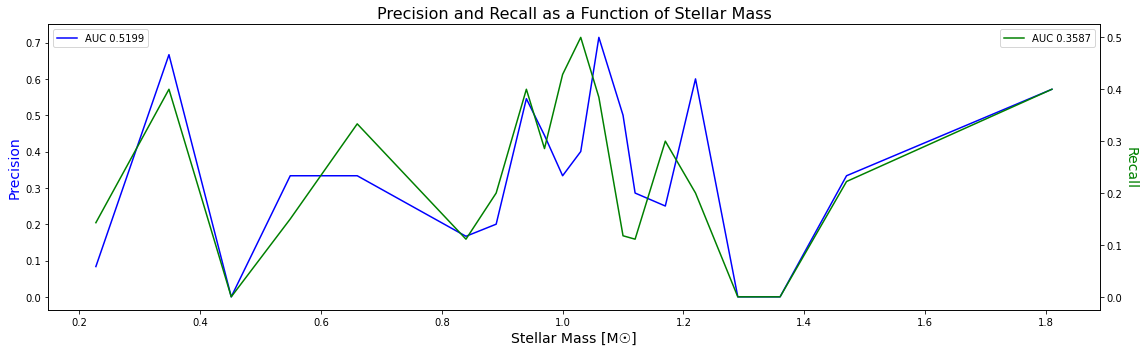

In [233]:
utils.show_featu_preci_recal(x_full_predi_data, predi, y_predi_data, cutof,
                             'stell_mass', 30)

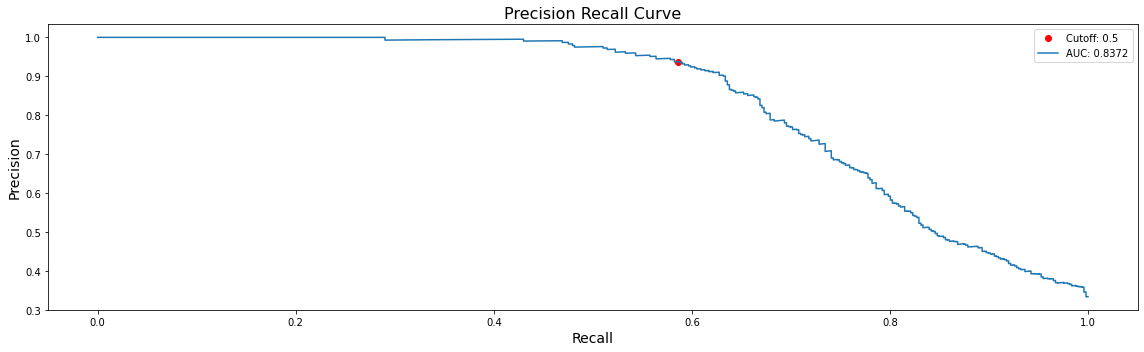

In [16]:
utils.show_preci_recal(predi, y_predi_data, cutof)

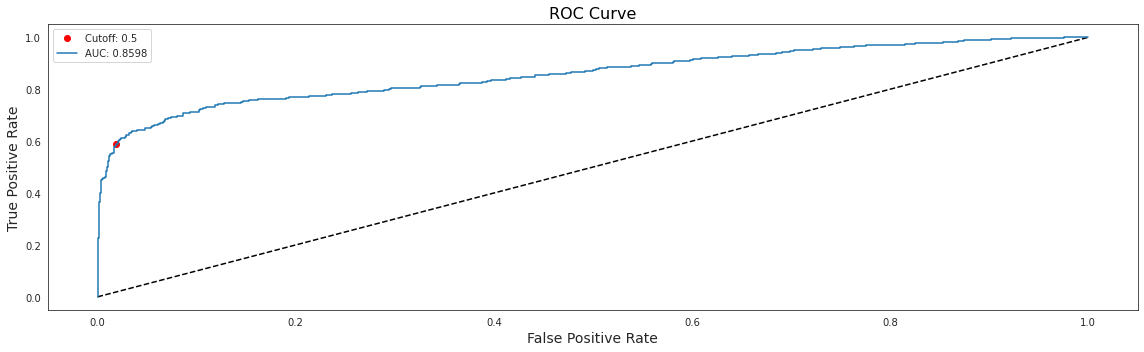

In [15]:
utils.show_roc(predi, y_predi_data, cutof)

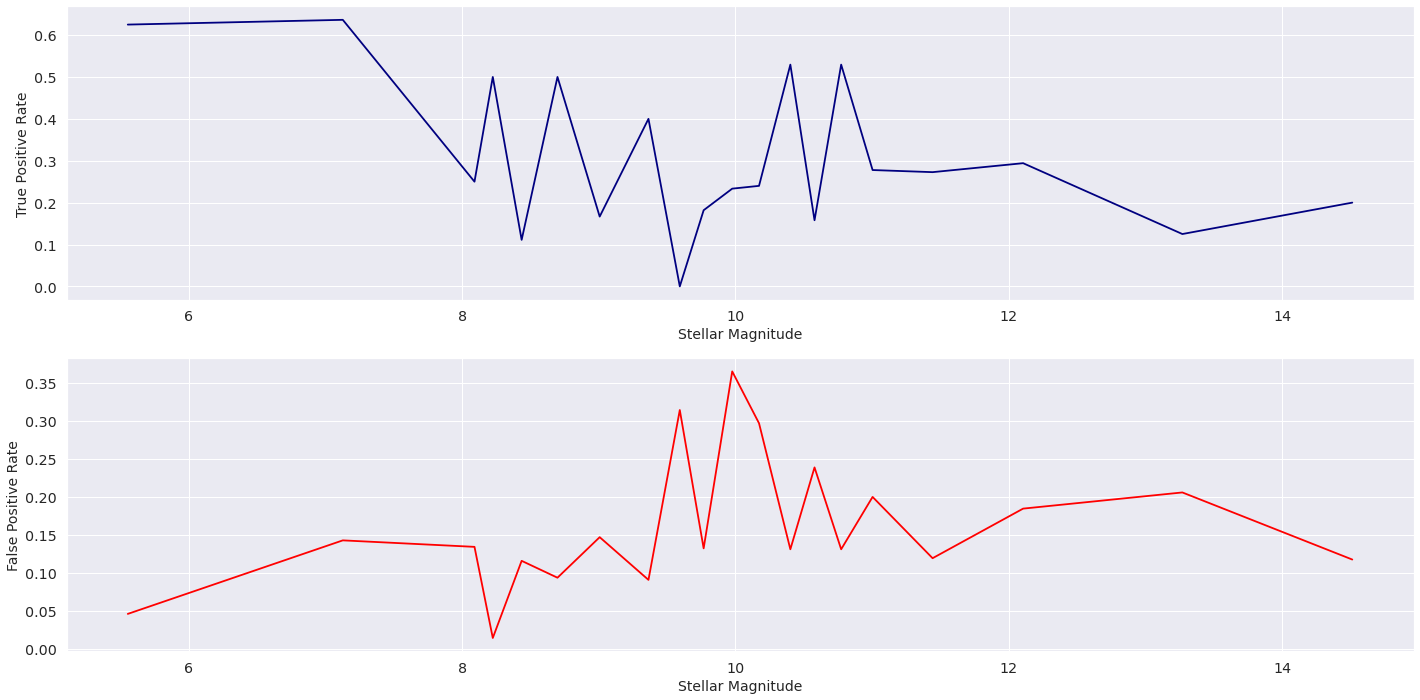

In [30]:
utils.show_tpr_fpr(x_full_predi_data, predi, cutof, 'stell_magni', 20, False)

In [22]:
importlib.reload(utils);

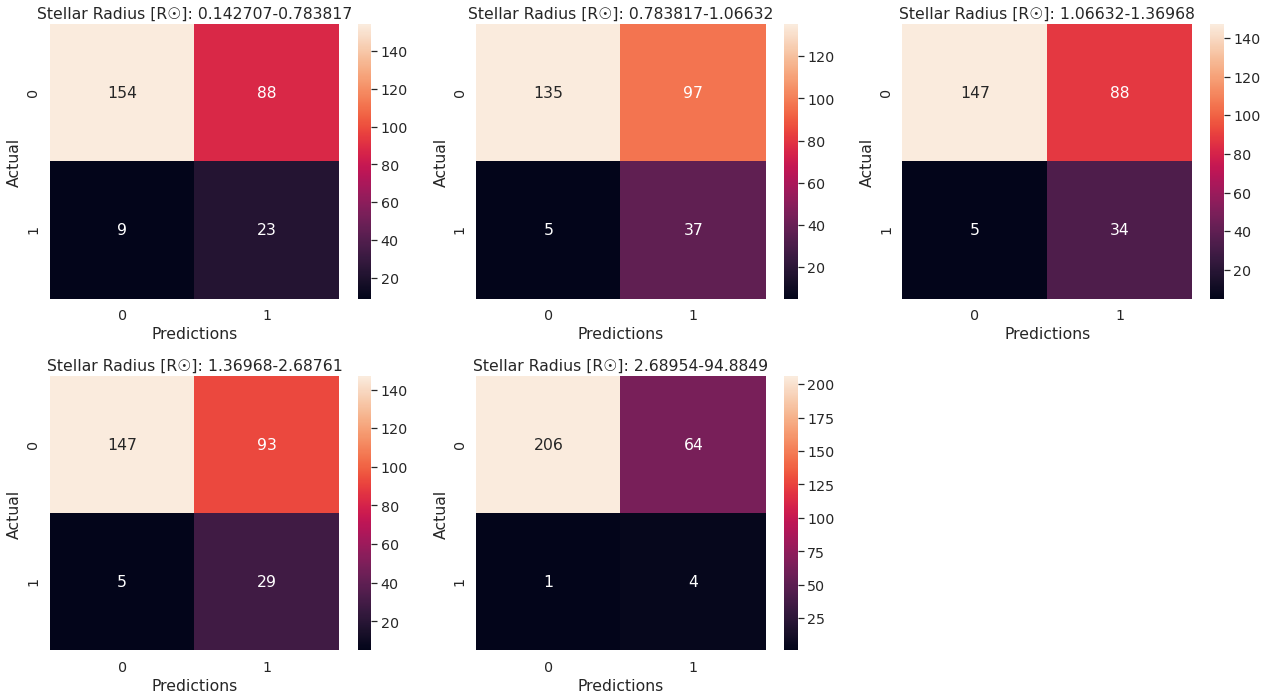

In [23]:
utils.show_confu_matri(x_full_predi_data, predi, cutof, 'stell_radiu', 5)

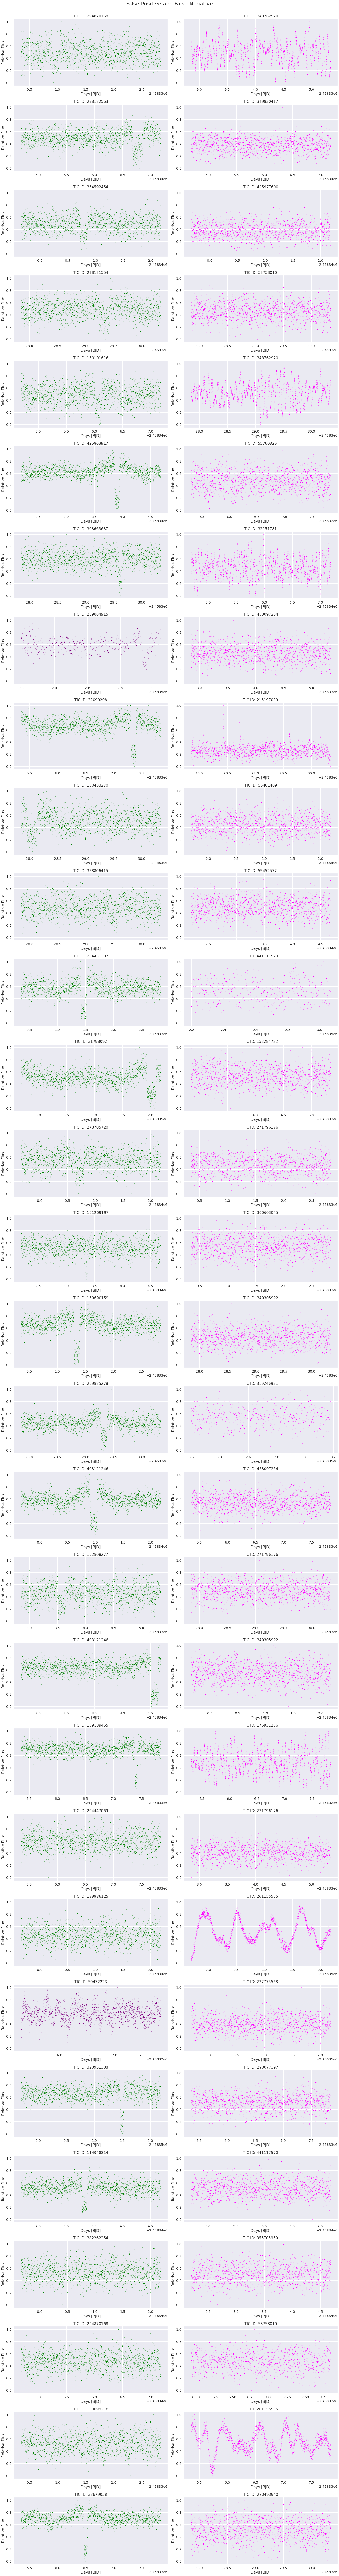

In [24]:
utils.show_predi_compa(x_full_predi_data, predi, cutof, [0,30], 'false')

#### Formatting

In [234]:
forma = \
'''
utils.show_featu_preci_recal(x_full_predi_data, predi, y_predi_data, cutof, 'stell_mass', 30)
'''
forma_done = FormatCode(forma, style_config='PEP8')
print(forma_done[0])

utils.show_featu_preci_recal(x_full_predi_data, predi, y_predi_data, cutof,
                             'stell_mass', 30)

